In [1]:
from __future__ import division, print_function
from keras import backend as K
from keras.applications import Xception
from keras.layers import Input, merge, SeparableConv2D, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Dense,Input, Flatten
from keras.layers import Activation, Dense, Dropout, Lambda, GlobalMaxPooling2D, BatchNormalization
from keras.models import Sequential, Model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from random import shuffle
from scipy.misc import imresize
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.engine import InputSpec, Layer
from keras import activations
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras import layers
from keras.utils.conv_utils import conv_output_length
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm_notebook

import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
import sys
import cv2

%matplotlib inline

/home/vlados/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATA_DIR = "/media/vlados/FreeSpace/Kaggle/Humpback"
IMAGE_DIR = os.path.join(DATA_DIR, "siames dataset")
TEST_DIR = os.path.join(DATA_DIR, 'test_dataset_2', 'test')

WIDTH = 299
HEIGHT = 299
seed = 1

In [13]:
image_groups = {}

for image_name in os.listdir(IMAGE_DIR):
    base_name = image_name[0:-4]
    group_name = base_name[0:4]
    
    if group_name in image_groups:
        image_groups[group_name].append(image_name)
    else:
        image_groups[group_name] = [image_name]

num_sim = 0
image_triples = []
group_list = sorted(list(image_groups.keys()))

for i, g in enumerate(group_list):
    if num_sim % 100 == 0:
        print("Generated {:d} pos + {:d} neg = {:d} total image triples"
              .format(num_sim, num_sim, 2*num_sim), end="\r")
    images_in_group = image_groups[g]

    # generate similar pairs
    sim_pairs_it = itertools.combinations(images_in_group, 2)
    
    # for each similar pair, generate a different pair
    
    for ref_image, sim_image in sim_pairs_it:
        image_triples.append((ref_image, sim_image, 1))
        num_sim += 1
        
        while True:
            j = np.random.randint(low=0, high=len(group_list), size=1)[0]
            if j != i: break
        
        dif_image_candidates = image_groups[group_list[j]]
        k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
        dif_image = dif_image_candidates[k]
        image_triples.append((ref_image, dif_image, 0))
        
print("Generated {:d} pos + {:d} neg = {:d} total image triples, COMPLETE"
      .format(num_sim, num_sim, 2*num_sim))

Generated 66912 pos + 66912 neg = 133824 total image triples, COMPLETE


In [0]:
split_point = int(len(image_triples) * 0.8)
triples_train, triples_test = image_triples[0:split_point], image_triples[split_point:]

In [0]:
def cached_imread(image_path, image_cache, img_size):
    
    if image_path not in image_cache:
        image = plt.imread(image_path)
        image = cv2.resize(image, (img_size, img_size))
        image_cache[image_path] = image    
    
    return image_cache[image_path]

def preprocess_images(image_names, seed, datagen, image_cache, img_size=299):
    np.random.seed(seed)
    X = np.zeros((len(image_names), WIDTH, HEIGHT, 3))
    
    for i, image_name in enumerate(image_names):
        image = cached_imread(os.path.join(IMAGE_DIR, image_name), image_cache, img_size)
        X[i] = datagen.random_transform(image)

    return X

def image_triple_generator(image_triples, batch_size, size):
    
    datagen_args = dict(rotation_range=10,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        preprocessing_function=preprocess_input)
    
    datagen_left = ImageDataGenerator(**datagen_args)
    datagen_right = ImageDataGenerator(**datagen_args)
    image_cache = {}
    
    while True:
        # loop once per epoch
        num_recs = len(image_triples)
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        
        for bid in range(num_batches):
            # loop once per batch
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [image_triples[i] for i in batch_indices]
            
            # make sure image data generators generate same transformations
            seed = np.random.randint(low=0, high=1000, size=1)[0]
            
            Xleft = preprocess_images([b[0] for b in batch], seed, 
                                      datagen_left, image_cache, img_size=size)
            
            Xright = preprocess_images([b[1] for b in batch], seed,
                                       datagen_right, image_cache, img_size=size)
            
#             Y = np_utils.to_categorical(np.array([b[2] for b in batch]))
            Y = np.array([b[2] for b in batch])
        
            
            yield ([Xleft, Xright], Y)

In [16]:
triples_batch_gen = image_triple_generator(image_triples, 8, WIDTH)
[Xleft, Xright], Y = next(triples_batch_gen)
print(Xleft.shape, Xright.shape, Y)

(8, 299, 299, 3) (8, 299, 299, 3) [0 0 1 0 1 0 1 0]


In [3]:
def create_base_network(input_shape):
    xception = Xception(weights='imagenet', 
                         include_top=True, 
                         input_shape=input_shape)
     
    model = Model(input=xception.input,
                 output=xception.get_layer("avg_pool").output)
    
    return model

def cosine_distance(vecs, normalize=False):
    x, y = vecs
    if normalize:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)

def cosine_distance_output_shape(shapes):
    return shapes[0]

def compute_accuracy(preds, labels):
    return labels[preds.ravel() < 0.5].mean()

In [4]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [6]:
input_shape = (299, 299, 3)
base_network = create_base_network(input_shape)

image_left = Input(shape=input_shape)
image_right = Input(shape=input_shape)

vector_left = base_network(image_left)
vector_right = base_network(image_right)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([vector_left, vector_right])
    
# Add a dense layer with a sigmoid unit to generate the similarity score
prediction = Dense(1,activation='sigmoid', bias_initializer=initialize_bias)(L1_distance)

x_corr_mod = Model(inputs=[image_left, image_right], outputs=prediction)

x_corr_mod.load_weights(os.path.join(DATA_DIR, '02-085.h5py'))

/home/vlados/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  import sys


In [10]:
x_corr_mod.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
x_corr_mod.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2048)         20861480    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2048)         0           model_1[1][0]                    
          

In [27]:
NUM_EPOCHS = 2
BATCH_SIZE = 14

filepath = os.path.join(DATA_DIR, "{epoch:02d}-{val_acc:.2f}.h5py")

callback = ModelCheckpoint(filepath, save_best_only=False, save_weights_only=False, period=1)

image_cache = {}
train_gen = image_triple_generator(triples_train, BATCH_SIZE, WIDTH)
val_gen = image_triple_generator(triples_test, BATCH_SIZE, WIDTH)

num_train_steps = len(triples_train) // BATCH_SIZE
num_val_steps = len(triples_test) // BATCH_SIZE

history = x_corr_mod.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=NUM_EPOCHS,
                              validation_data=val_gen,
                              validation_steps=num_val_steps,
                              callbacks=[callback])

Epoch 1/2
7647/7647 [==============================] - 21131s 3s/step - loss: 0.4792 - acc: 0.7688 - val_loss: 0.4050 - val_acc: 0.8241
Epoch 2/2
7647/7647 [==============================] - 17966s 2s/step - loss: 0.3238 - acc: 0.8659 - val_loss: 0.3622 - val_acc: 0.8499


In [25]:
train_imges_path = []
test_imges_path = []

for path in tqdm_notebook(sorted(os.listdir(IMAGE_DIR))):
    train_imges_path.append(os.path.join(IMAGE_DIR, path))
for path in tqdm_notebook(sorted(os.listdir(TEST_DIR))):
    test_imges_path.append(os.path.join(TEST_DIR, path))

In [89]:
def load_dataset(train_imges_path):    
    dataset = np.zeros(len(train_imges_path))
    
    for i, path in tqdm_notebook(enumerate(train_imges_path)):
        dataset[i] = cv2.imread(path)
        
        return dataset

In [52]:
def preprocess_img(path2img, size=299):
    img = cv2.imread(path2img)
    img = cv2.resize(img, (size, size))
#     img = test_img.astype(np.float32)
#     img = preprocess_input(img)
    
    return img

In [50]:
def batch_generator(batch):
    while True:
    
        left_part = np.zeros((batch, 299, 299, 3))
        right_part = np.zeros((batch, 299, 299, 3))
        
        for i, path in enumerate(test_imges_path):
            left_part[:,:,:,:] = preprocess_img(path)
            
            for j in range(len(train_imges_path)//batch):
                chunk = train_imges_path[j*batch : (j+1)*batch]
                
                for k, path in enumerate(chunk):
                    right_part[k] = preprocess_img(path)
        
                yield [left_part, right_part]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


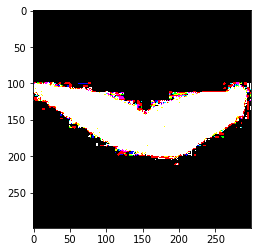

In [59]:
plt.imshow(next(batch_generator(10)))

In [60]:
def model_testing(batch):
    predict = x_corr_mod.predict_generator(batch_generator(batch), max_queue_size=10, steps=1000,
                                           workers=5, use_multiprocessing=True, verbose=1)[:,0]
            
model_testing(10)

/home/vlados/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2487: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/vlados/anaconda3/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/home/vlados/anaconda3/lib/python3.6/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/home/vlados/anaconda3/lib/python3.6/multiprocessing/managers.py", line 756, in _callmethod
    conn.send((self._id, methodname, args, kwds))
  File "<string>", line 2, in put
  File "/home/vlados/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_outpu

KeyboardInterrupt: 